In [3]:
import numpy as np
import matplotlib.pyplot as plt

from curve_generator import ellipse_function, generate_periodic_helicoid_curve
from poisson_solver_v2 import poisson_solve
from intersection_calculations import SignedIntersection
from levi_civita import levi_civita_symbol
from compute_area import compute_area_vector

from zero_form import ZeroForm
from one_form import OneForm

from visualizer import visualize_1form_with_colors

# Grid

First step is to create a grid mesh for discretizing the space.

In [4]:
def generate_grid_mesh(N = 32):
    L = 1.0
    h = L / N
    # Create the array of vertices, xyz indexing.
    V_ind = np.asarray([[[[i,j,k] for k in range(N)] for j in range(N)] for i in range(N)])
    V = V_ind * h
    return (V_ind, V)

In [ ]:
N = 32
V_ind, V = generate_grid_mesh(N = N)

# Boundary curve

Now for example we can take a simple circle curve, we position the center point at $(0.5, 0.5, 0.5)$ and set the radius to $0.25$.  

In [6]:
def gamma_triangle(t, A, B, C):
    """
    Parameterizes a triangle given three vertices A, B, and C.
    
    Args:
        t (float): Parameter in [0,1] to get a corresponding point on the curve.
        A (ndarray): First vertex of the triangle (3D point).
        B (ndarray): Second vertex of the triangle (3D point).
        C (ndarray): Third vertex of the triangle (3D point).
        
    Returns:
        ndarray: A 3D point corresponding to the parameter t.
    """
    if t < 1/3:
        return (1 - 3*t) * A + 3*t * B
    elif t < 2/3:
        return (2 - 3*t) * B + (3*t - 1) * C
    else:
        return (3 - 3*t) * C + (3*t - 2) * A

In [27]:
curve_function = lambda t: ellipse_function(t, a = 0.2, b = 0.2, base_point=np.array([0.5, 0.5, 0.25]))
curve_function(0.25)

#curve_function = lambda t: generate_periodic_helicoid_curve(t, radius=0.4, num_turns=1) + np.array([0.5, 0.5, 0])
#curve_function(0.25)

# curve_function = lambda t: gamma_triangle(t, A = np.array([0.5, 0.5, 0.5]), B = np.array([0.5, 0.3, 0.5]), C = np.array([0.7, 0.5, 0.5]))

array([0.5, 0.7, 0.5])

### Simple $\mathbb{S}^1$

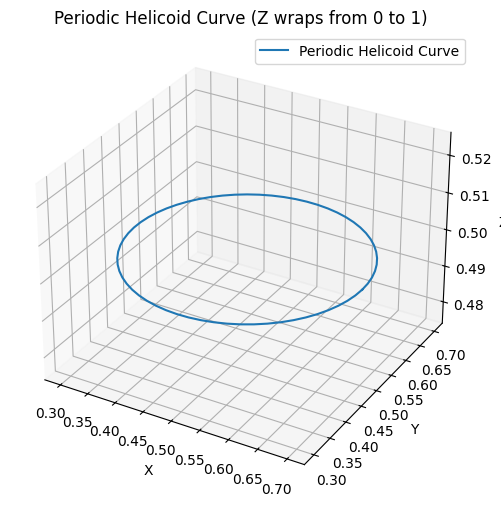

In [28]:
circle_t_range = np.linspace(0, 1, num = N)
curve_values = np.array([curve_function(t) for t in circle_t_range])
# Visualization
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(curve_values[:,0], curve_values[:,1], curve_values[:,2], label='Periodic Helicoid Curve')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Periodic Helicoid Curve (Z wraps from 0 to 1)")
ax.legend()
plt.show()

In [29]:
def correct_eta_0(eta_0_tilde, A):
    """
    Adjusts the initial guess eta_0 to enforce the correct cohomology condition.
    """
    A_error = A - np.array([np.sum(eta_0_tilde[..., i]) for i in range(3)])
    eta_0 = eta_0_tilde.copy()
    for i in range(3):
        eta_0[..., i] += A_error[i] / np.prod(eta_0.shape[:-1])  # Apply harmonic correction
    return eta_0

In [30]:
def compute_area_vector(t_values, curve_function):
    """
    Computes the area vector A by integrating over the helicoid boundary.
    """
    gamma_t = np.array([curve_function(t) for t in t_values])  # Sample boundary
    d_gamma_t = np.gradient(gamma_t, axis=0)  # Compute derivatives

    # Compute cross product integral
    A = 0.5 * np.sum(np.cross(gamma_t, d_gamma_t), axis=0)
    return A

In [31]:
def compute_flux(eta_0):
    """
    Computes the integral of eta_0 over fundamental periodic cycles.
    This checks whether the initial guess is in the right homology class.
    
    Returns:
        np.array: (3,) array of flux values in x, y, z directions.
    """
    Nx, Ny, Nz, D = eta_0.shape
    flux = np.zeros(D)
    h = 1.0 / N
    # Compute integral along periodic loops
    for i in range(D):
        flux[i] = np.sum(eta_0[..., i]) # Sum over all grid values

    return flux

In [32]:
import numpy as np
from itertools import permutations

def compute_initial_guess(V_ind, curve_function, t_values):
    """
    Computes the initial guess for the vector field eta_0 while ensuring correct cohomology.
    """
    h = 1.0 / t_values.shape[0]
    *shapes, D = V_ind.shape
    Nx, Ny, Nz = shapes
    V = V_ind * h

    # Compute delta_Gamma form as a discrete array
    delta_gamma = np.zeros_like(V_ind).astype(float)
    num_crossings = np.zeros_like(V_ind)
    curve_data = np.array([curve_function(t) for t in t_values])
    
    for x in range(Nx):
        for y in range(Ny):
            for z in range(Nz):
                for i in range(D):
                    face = (V[x, y, z], i, (h, h))
                    flux, n_crossings = SignedIntersection(curve_data, face)
                    delta_gamma[x, y, z, i] = flux
                    num_crossings[x, y, z, i] = n_crossings

    # Solve the Poisson equation for Psi
    Psi_list = []
    for i in range(D):
        psi_i = poisson_solve(ZeroForm(V_ind, scalar_field=delta_gamma[..., i]))
        Psi_list.append(psi_i)
    Psi = np.asarray(Psi_list)

    # Compute valid permutations for Levi-Civita symbol handling
    total_permutations = []
    for i in range(D):
        valid_perms = [(j, k) for j, k in permutations(range(D), 2) if levi_civita_symbol(i, j, k) == 1]
        if valid_perms:
            total_permutations.append(valid_perms[0])  # Pick first valid permutation
        else:
            total_permutations.append((0, 1))  # Fallback to default

    # Compute eta_0_tilde using Psi
    eta_0_tilde = np.zeros_like(V_ind).astype(float)
    for x in range(Nx):
        for y in range(Ny):
            for z in range(Nz):
                for i in range(D):
                    j, k = total_permutations[i]
                    prev_j = np.array([x, y, z])
                    prev_j[k] = (prev_j[k] + 1) % Nx
                    prev_k = np.array([x, y, z])
                    prev_k[j] = (prev_k[j] + 1) % Nx

                    # Compute eta_0_tilde
                    positive_terms = Psi[j, prev_j[0], prev_j[1], prev_j[2]] + Psi[k, prev_k[0], prev_k[1], prev_k[2]]
                    negative_terms = Psi[j, x, y, z] + Psi[k, x, y, z]
                    eta_0_tilde[x, y, z, i] = positive_terms - negative_terms

    k_space = [np.fft.fftfreq(Nx), np.fft.fftfreq(Ny), np.fft.fftfreq(Nz)]
    kx, ky, kz = np.meshgrid(k_space[0], k_space[1], k_space[2], indexing="ij")

    # Compute Fourier transform of Psi along spatial dimensions
    Psi_hat = np.fft.fftn(Psi, axes=(1, 2, 3))

    # Initialize eta_0 in Fourier space
    eta_0_hat = np.zeros_like(Psi_hat, dtype=np.complex128)

    # Apply differentiation operator in Fourier space
    eta_0_hat[0] = 2j * np.pi * (ky * Psi_hat[2] - kz * Psi_hat[1])  # x-component
    eta_0_hat[1] = 2j * np.pi * (kz * Psi_hat[0] - kx * Psi_hat[2])  # y-component
    eta_0_hat[2] = 2j * np.pi * (kx * Psi_hat[1] - ky * Psi_hat[0])  # z-component

    # Transform back to spatial domain
    eta_0 = np.fft.ifftn(eta_0_hat, axes=(1, 2, 3)).real  # Take only real part

    # Reshape to have the last axis as the vector components
    eta_0 = np.moveaxis(eta_0, 0, -1)  # Now shape is (Nx, Ny, Nz, 3)

    # Now eta_0 has shape (Nx, Ny, Nz, 3) as desired
    print(eta_0.shape)  # Should print (Nx, Ny, Nz, 3)

    # Compute area vector correction
    A = compute_area_vector(t_values, curve_function)
    eta_0 = correct_eta_0(eta_0, A)

    # Compute initial guess vector field X_0 using central finite difference
    X_0 = np.zeros_like(eta_0).astype(float)
    for i in range(D):
        X_0[..., i] = (np.roll(eta_0[..., i], -1, axis=i) - np.roll(eta_0[..., i], 1, axis=i)) / (2.0 * h)
    
    return {
        'X_0': X_0,
        'Psi': Psi,
        'eta_0': eta_0,
        'eta_0_tilde': eta_0_tilde,
        'A': A,
        'delta_gamma': delta_gamma,
    }


In [13]:
data = compute_initial_guess(V_ind=V_ind, curve_function=curve_function, t_values=circle_t_range)

(64, 64, 64, 3)


## Visualize the initial guess


In [14]:
first_guess_form = OneForm(V_ind, vector_field=data['X_0'].copy())

<Axes3D: >

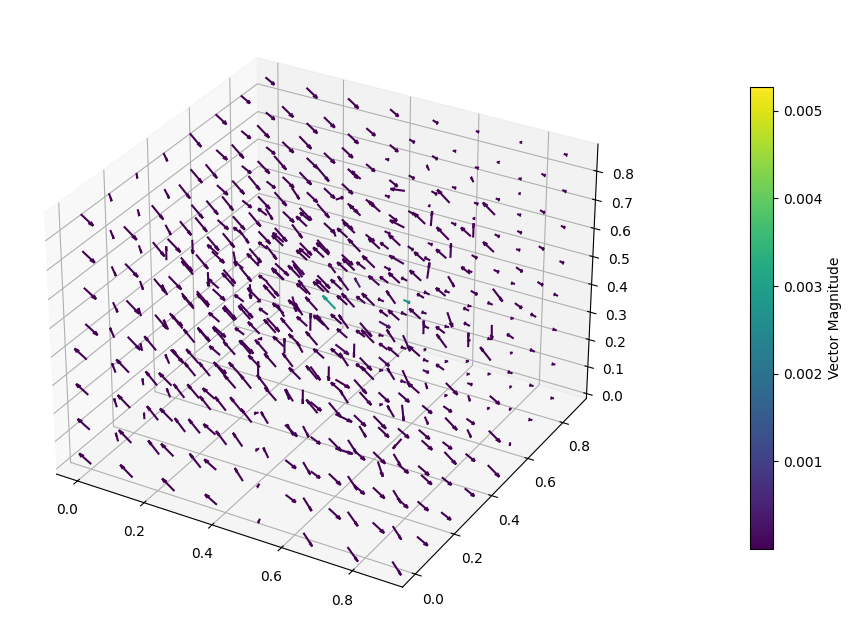

In [15]:
ax = plt.figure(figsize=(16, 8)).add_subplot(projection = '3d')
visualize_1form_with_colors(ax, V, first_guess_form, length=0.05, stride=N // 8)

### Slices visualized

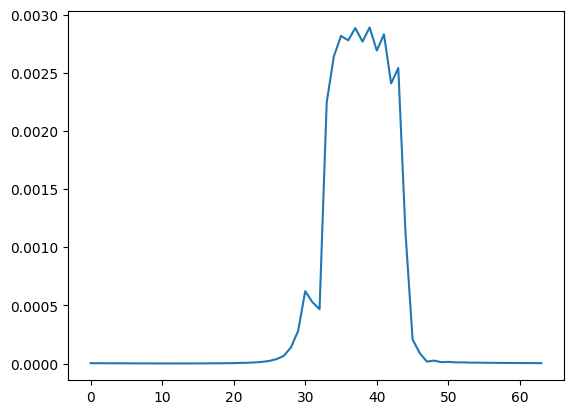

In [16]:
plt.plot(np.linalg.norm(first_guess_form.vector_field, axis = -1)[:, N // 2, N // 2])

In [17]:
def compute_codivergence(X_vectorfield):
    """
    Computes the codivergence (δX = ⋆ d ⋆ X) of a vector field X.

    Parameters:
        X_vectorfield: NumPy array of shape (Nx, Ny, Nz, 3), representing a discrete 1-form field.

    Returns:
        codiv_X: NumPy array of shape (Nx, Ny, Nz), representing the scalar field δX.
    """

    Nx, Ny, Nz, _ = X_vectorfield.shape

    # Step 1: Compute Hodge star (convert X to 2-form)
    X_dual = np.zeros_like(X_vectorfield)
    X_dual[..., 0] = X_vectorfield[..., 1]  # ⋆(dx) = dy∧dz
    X_dual[..., 1] = -X_vectorfield[..., 0] # ⋆(dy) = -dx∧dz
    X_dual[..., 2] = X_vectorfield[..., 2]  # ⋆(dz) = dx∧dy

    # Step 2: Compute exterior derivative d(⋆X) using finite differences
    dX_dual = np.zeros((Nx, Ny, Nz, 3))
    
    # Forward difference approximation for d(⋆X)
    dX_dual[..., 0] = np.roll(X_dual[..., 0], -1, axis=0) - X_dual[..., 0]  # ∂x
    dX_dual[..., 1] = np.roll(X_dual[..., 1], -1, axis=1) - X_dual[..., 1]  # ∂y
    dX_dual[..., 2] = np.roll(X_dual[..., 2], -1, axis=2) - X_dual[..., 2]  # ∂z

    # Step 3: Compute final Hodge star to obtain codivergence
    codiv_X = dX_dual[..., 0] + dX_dual[..., 1] + dX_dual[..., 2]  # Sum over all directions

    return codiv_X



# Main algorithm

In [18]:
def algorithm_1(lambda_hat: np.array, X_0: np.array, X_hat: np.array, tau: float = 0.1) -> np.array:
    assert tau > 0, "hyperparameter tau should be positive."

    Y = X_hat - X_0 - (1 / tau) * lambda_hat

    # D^T Y and then solve the poisson equation
    D_Y_form = ZeroForm(V_ind, scalar_field=-compute_codivergence(Y))
    phi = poisson_solve(D_Y_form)
    return phi

In [19]:
def algorithm_2(lambda_hat: np.array, X_0: np.array, d_phi: np.array, tau: float = 0.1):
    assert tau > 0, "Hyperparameter tau should be positive."

    # Compute Z
    Z = tau * lambda_hat + d_phi + X_0

    # Convert to OneForm object
    Z_form = OneForm(V_ind, vector_field=Z)

    # Compute vertex-wise norms
    Z_norm = np.maximum(Z_form.vertex_norms(), 1e-8)  # Avoid zero-division

    # Create mask for shrinkage condition
    if_mask = (Z_norm * tau > 1.0)  # Ensure shape matches Z

    # Initialize output array
    X = np.zeros_like(Z)

    # Apply shrinkage where needed
    X[if_mask] = (1 - (1 / (tau * Z_norm[if_mask])))[:, np.newaxis] * Z[if_mask]

    return X

In [20]:
def solve_plateau(V_ind, X_0, tau=1.0, rho=0.4, max_iter=50):
    """
    Implements the ADMM-based solver for the minimal surface problem.

    Parameters:
        V_ind: The discrete grid domain.
        X_0: Initial guess for the vector field.
        tau: Step size.
        rho: Acceleration threshold.
        max_iter: Number of iterations.

    Returns:
        X: The optimized vector field representing the minimal surface.
    """
    X = X_0.copy().astype(float)
    X_hat = X_0.copy().astype(float)
    lambda_ = np.zeros_like(X_0).astype(float)  # Start with zeros for stability
    lambda_hat = np.zeros_like(X_0).astype(float)
    alpha = 0.1
    c_prev = np.inf
    h = 1.0 / V_ind.shape[0]

    lambda_prev = lambda_.copy()
    X_prev = X.copy()

    print(f"Initial Mass of X: {OneForm(V_ind, vector_field=X_0).mass}")

    for k in range(max_iter):
        if k > 0:
            X_prev = X.copy()
            lambda_prev = lambda_.copy()
            c_prev = c

        # Solve for φ using the Poisson solver
        phi = algorithm_1(lambda_hat=lambda_hat, X_0=X_0, X_hat=X_hat, tau=tau)
        phi_form = ZeroForm(V_ind, scalar_field=phi)
        d_phi = phi_form.differentiation()
        
        # Solve for X using shrinkage
        X = algorithm_2(lambda_hat=lambda_hat, X_0=X_0, d_phi=d_phi, tau=tau)
        X_form = OneForm(V_ind, vector_field=X)

        error = d_phi - X + X_0
        error_form = OneForm(V_ind, vector_field=error)

        # Update lambda
        lambda_ = lambda_hat + tau * error

        # Compute convergence criteria with normalized norms
        grid_size = np.prod(V_ind.shape[:-1])  # Avoid large artifacts
        c = (1 / tau) * (np.linalg.norm(lambda_ - lambda_hat) ** 2 / grid_size) + \
            (tau * np.linalg.norm(X - X_hat) ** 2 / grid_size)

        print(f"Iteration {k+1}:")
        print(f"  Mass of X: {X_form.mass}")
        print(f"  Flux of X: {compute_flux(X) * h ** 3}")
        print(f"  Error mass: {error_form.mass}")
        print(f"  Convergence criteria: {c:.6f}")
        print(f"  Dphi Max Norm: {np.linalg.norm(d_phi.reshape(-1, d_phi.shape[-1]), axis=-1).max():.6f}")
        print(f"  X - X_0 Max Norm: {np.linalg.norm((X - X_hat).reshape(-1, X.shape[-1]), axis=-1).max():.6f}")

        # Stopping Condition (optional)
        if c < 1e-6:
            print("Converged!")
            break

        # Acceleration update
        if c < rho * c_prev:
            alpha_new = (1 + np.sqrt(1 + 4 * alpha ** 2)) / 2
            lambda_hat = lambda_ + (alpha - 1) / alpha_new * (lambda_ - lambda_prev)
            X_hat = X + (alpha - 1) / alpha_new * (X - X_prev)
            alpha = alpha_new
        else:
            lambda_hat = lambda_
            X_hat = X
            alpha = 1
            c = c_prev / rho

    return X, (X_0 + d_phi)


In [21]:
compute_flux(data['X_0'])

array([-1.23684016e-17,  1.07229607e-17, -3.50883398e-18])

In [22]:
X, eta = solve_plateau(V_ind = V_ind, X_0 = (data['X_0'] / data['X_0'].max()).copy(), max_iter=64)

Initial Mass of X: 0.003614464742892843
Iteration 1:
  Mass of X: 7.789551422642088e-06
  Flux of X: [-4.54949337e-22  5.44615715e-21 -7.72917564e-21]
  Error mass: 0.003606675191470201
  Convergence criteria: 0.002166
  Dphi Max Norm: 0.000000
  X - X_0 Max Norm: 1.000000
Iteration 2:
  Mass of X: 2.242211472037699e-05
  Flux of X: [-1.02082370e-08  7.11220020e-09 -3.55270397e-09]
  Error mass: 0.003594070336834871
  Convergence criteria: 0.001892
  Dphi Max Norm: 0.002046
  X - X_0 Max Norm: 0.802133
Iteration 3:
  Mass of X: 0.000811393178250101
  Flux of X: [-2.04211319e-06  1.56856378e-06  9.77014839e-07]
  Error mass: 0.002824323894912563
  Convergence criteria: 0.000848
  Dphi Max Norm: 0.019261
  X - X_0 Max Norm: 0.909836
Iteration 4:
  Mass of X: 0.001183570419352644
  Flux of X: [-2.16477801e-06  2.27530972e-06  4.91897645e-07]
  Error mass: 0.0024607691845715874
  Convergence criteria: 0.000317
  Dphi Max Norm: 0.018037
  X - X_0 Max Norm: 0.475163
Iteration 5:
  Mass of X:

In [23]:
np.save('./data/X.npy', arr=X)
np.save('./data/X_0.npy', arr=data['X_0'])

In [24]:
np.save('./data/eta.npy', arr=eta)

## Visualize the optimal surface

<Axes3D: >

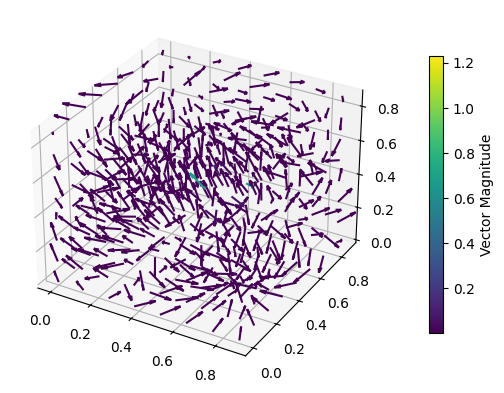

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
visualize_1form_with_colors(ax, grid = V, one_form=OneForm(V_ind, vector_field=eta.copy()), stride= N // 8)

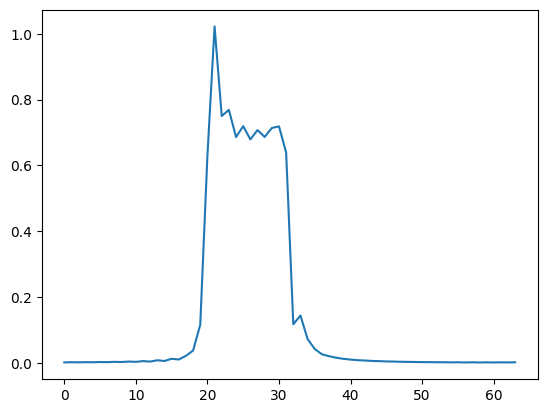

In [26]:
plt.plot(np.linalg.norm(eta, axis = -1)[N // 2, :, N // 2])